In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
import sys,os
import rdkit
import networkx as nx
import pandas as pd

In [4]:
traintest=pd.concat([pd.read_csv("../input/train.csv",index_col=0),
                 pd.read_csv("../input/test.csv",index_col=0)]).reset_index()

/home/bo/miniconda2/envs/deepchem/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/bo/miniconda2/envs/deepchem/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
traintest.head()

id  atom_index_0  atom_index_1     molecule_name  scalar_coupling_constant  \
0   0             1             0  dsgdb9nsd_000001                   84.8076   
1   1             1             2  dsgdb9nsd_000001                  -11.2570   
2   2             1             3  dsgdb9nsd_000001                  -11.2548   
3   3             1             4  dsgdb9nsd_000001                  -11.2543   
4   4             2             0  dsgdb9nsd_000001                   84.8074   

   type  
0  1JHC  
1  2JHH  
2  2JHH  
3  2JHH  
4  1JHC

In [6]:
traintest.shape

(7163689, 6)

In [7]:
names = set(traintest['molecule_name'])
len(names)

130775

In [33]:
qm9mols={}
suppl = Chem.SDMolSupplier('../input/qm9/gdb9.sdf',removeHs=False,sanitize=False) #if sanitize is true some mols is missing
for mol in suppl:
    if 1:
        name=int(mol.GetProp("_Name").split("_")[-1])
        name="dsgdb9nsd_{:06}".format(name)
        if name in names:
            mol.SetProp("_Name", name)
            qm9mols[name]=mol
        #break
len(qm9mols)

130775

In [34]:
names.difference(qm9mols.keys())

set()

In [35]:
def check_mol(moldict,row):
    err_msg=""
    i,j=row[['atom_index_0','atom_index_1']].values
    
    molname = row['molecule_name']
    key=(molname, i, j)
    if molname not in moldict:
        err_msg = molname+" not found"
    else:
        mol = moldict[molname] 
        
        bondtype=row['type']
        ai,aj=mol.GetAtomWithIdx(int(i)),mol.GetAtomWithIdx(int(j))
        si,sj=ai.GetSymbol(),aj.GetSymbol()
        sp = rdkit.Chem.rdmolops.GetShortestPath(mol,int(i), int(j))
        if bondtype.endswith(si+sj) or bondtype.endswith(sj+si):
            pass
        else:
            err_msg = ("atom error", row.values, si,sj)

        if int(bondtype[0])+1 == len(sp):
            pass
        else:
            err_msg =  ("bond error", row.values, sp)        
    return (key,str(err_msg))
    

# check qm9 bonds

In [36]:
from tqdm import tqdm_notebook

In [38]:
openbabelchecks={}
for i in tqdm_notebook(range(len(traintest))):
    row = traintest.iloc[i]
    key,msg = check_mol(qm9mols,row)
    openbabelchecks[key]=msg


In [39]:
df=pd.Series(openbabelchecks).to_frame()
df=df.reset_index()
df.columns=['molname','idx0','idx1','msg']
df['has_error']=df['msg'].map(lambda u: u!="")
df.head()

molname  idx0  idx1 msg  has_error
0  dsgdb9nsd_000001     1     0          False
1  dsgdb9nsd_000001     1     2          False
2  dsgdb9nsd_000001     1     3          False
3  dsgdb9nsd_000001     1     4          False
4  dsgdb9nsd_000001     2     0          False

In [40]:
df['has_error'].sum()

2092

In [43]:
dferror = df[df['has_error']]

In [44]:
dferror.to_csv("../input/qm9checks.status.csv",index=None)

In [42]:
vc = dferror[dferror['msg'].map(lambda u: "not found" in u)]['molname'].value_counts()
print (vc.shape)
vc

(0,)


Series([], Name: molname, dtype: int64)

In [45]:
with pd.option_context('display.max_colwidth', -1):
    display(dferror[dferror['msg'].map(lambda u: "not found" not in u)])

molname  idx0  idx1  \
1903     dsgdb9nsd_000106  7     3      
1918     dsgdb9nsd_000106  10    1      
13408    dsgdb9nsd_000652  10    4      
13424    dsgdb9nsd_000652  13    2      
13491    dsgdb9nsd_000654  8     4      
13506    dsgdb9nsd_000654  11    2      
14519    dsgdb9nsd_000697  9     4      
14524    dsgdb9nsd_000697  10    2      
14592    dsgdb9nsd_000699  8     4      
14597    dsgdb9nsd_000699  9     2      
43394    dsgdb9nsd_001898  11    4      
47250    dsgdb9nsd_002007  9     2      
47378    dsgdb9nsd_002010  10    2      
47530    dsgdb9nsd_002018  12    2      
48753    dsgdb9nsd_002044  13    5      
48770    dsgdb9nsd_002044  16    3      
48796    dsgdb9nsd_002046  11    5      
48812    dsgdb9nsd_002046  14    3      
61128    dsgdb9nsd_002411  11    4      
61134    dsgdb9nsd_002411  12    2      
61456    dsgdb9nsd_002422  12    6      
61461    dsgdb9nsd_002422  13    4      
61478    dsgdb9nsd_002423  10    1      
92963    dsgdb9nsd_003495  9     5      
92979    dsgdb9nsd_003495  12    3      
93045    dsgdb9nsd_003499  8     5      
93061    dsgdb9nsd_003499  11    3      
93120    dsgdb9nsd_003502  9     5      
93136    dsgdb9nsd_003502  12    3      
93264    dsgdb9nsd_003506  13    5      
...                   ...  ..   ..      
6847498  dsgdb9nsd_114267  18    4      
6944969  dsgdb9nsd_118705  17    7      
6944985  dsgdb9nsd_118705  20    5      
6945029  dsgdb9nsd_118707  17    7      
6945045  dsgdb9nsd_118707  20    5      
6945093  dsgdb9nsd_118709  17    7      
6945110  dsgdb9nsd_118709  20    5      
6961906  dsgdb9nsd_119385  16    3      
6968245  dsgdb9nsd_119655  16    3      
6968458  dsgdb9nsd_119663  17    8      
6968463  dsgdb9nsd_119663  18    6      
6968626  dsgdb9nsd_119672  17    8      
6968631  dsgdb9nsd_119672  18    6      
6968814  dsgdb9nsd_119675  16    8      
6968819  dsgdb9nsd_119675  17    6      
6978791  dsgdb9nsd_120082  16    7      
6978796  dsgdb9nsd_120082  17    5      
6978843  dsgdb9nsd_120084  15    7      
6978848  dsgdb9nsd_120084  16    5      
6980292  dsgdb9nsd_120157  14    1      
6980445  dsgdb9nsd_120167  15    6      
6980903  dsgdb9nsd_120204  15    6      
6980908  dsgdb9nsd_120204  16    4      
7030182  dsgdb9nsd_122365  17    7      
7030197  dsgdb9nsd_122365  20    5      
7030333  dsgdb9nsd_122370  17    7      
7030349  dsgdb9nsd_122370  20    5      
7159355  dsgdb9nsd_133552  11    4      
7159528  dsgdb9nsd_133566  10    7      
7159544  dsgdb9nsd_133566  13    5      

                                                                                                                            msg  \
1903     ('bond error', array([1903, 7, 3, 'dsgdb9nsd_000106', 3.03533, '3JHC'], dtype=object), (7, 1, 3))                        
1918     ('bond error', array([1918, 10, 1, 'dsgdb9nsd_000106', 3.03538, '3JHC'], dtype=object), (10, 3, 1))                      
13408    ('bond error', array([13408, 10, 4, 'dsgdb9nsd_000652', 3.5805300000000004, '3JHC'],\n      dtype=object), (10, 2, 4))   
13424    ('bond error', array([13424, 13, 2, 'dsgdb9nsd_000652', 3.5798400000000004, '3JHC'],\n      dtype=object), (13, 4, 2))   
13491    ('bond error', array([13491, 8, 4, 'dsgdb9nsd_000654', 4.4938400000000005, '3JHC'],\n      dtype=object), (8, 2, 4))     
13506    ('bond error', array([13506, 11, 2, 'dsgdb9nsd_000654', 5.07205, '3JHC'], dtype=object), (11, 4, 2))                     
14519    ('bond error', array([14519, 9, 4, 'dsgdb9nsd_000697', 1.23831, '3JHC'], dtype=object), (9, 2, 4))                       
14524    ('bond error', array([14524, 10, 2, 'dsgdb9nsd_000697', 1.2383, '3JHC'], dtype=object), (10, 4, 2))                      
14592    ('bond error', array([14592, 8, 4, 'dsgdb9nsd_000699', 3.63795, '3JHC'], dtype=object), (8, 2, 4))                       
14597    ('bond error', array([14597, 9, 2, 'dsgdb9nsd_000699', 4.94471, '3JHC'], dtype=object), (9, 4, 2))                       
43394    ('bond error', array([433

In [46]:
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize=(600,400)


In [47]:
 
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

molname  idx0  idx1  \
47530  dsgdb9nsd_002018  12    2      

                                                                                                        msg  \
47530  ('bond error', array([47530, 12, 2, 'dsgdb9nsd_002018', 2.67329, '3JHC'], dtype=object), (12, 4, 2))   

       has_error  
47530  True

molname  idx0  idx1  \
61128  dsgdb9nsd_002411  11    4      
61134  dsgdb9nsd_002411  12    2      

                                                                                                        msg  \
61128  ('bond error', array([61128, 11, 4, 'dsgdb9nsd_002411', 3.53499, '3JHC'], dtype=object), (11, 2, 4))   
61134  ('bond error', array([61134, 12, 2, 'dsgdb9nsd_002411', 3.5332, '3JHC'], dtype=object), (12, 4, 2))    

       has_error  
61128  True       
61134  True

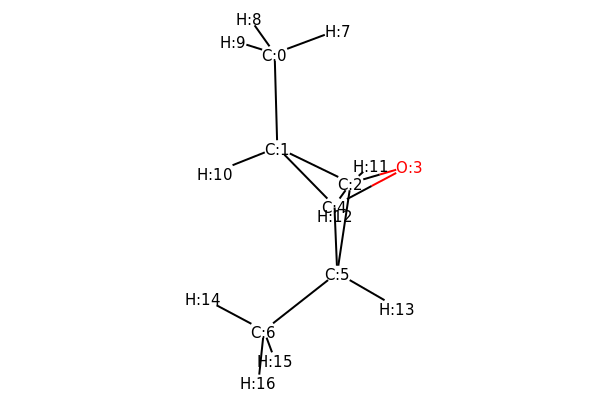

molname  idx0  idx1  \
14592  dsgdb9nsd_000699  8     4      
14597  dsgdb9nsd_000699  9     2      

                                                                                                      msg  \
14592  ('bond error', array([14592, 8, 4, 'dsgdb9nsd_000699', 3.63795, '3JHC'], dtype=object), (8, 2, 4))   
14597  ('bond error', array([14597, 9, 2, 'dsgdb9nsd_000699', 4.94471, '3JHC'], dtype=object), (9, 4, 2))   

       has_error  
14592  True       
14597  True

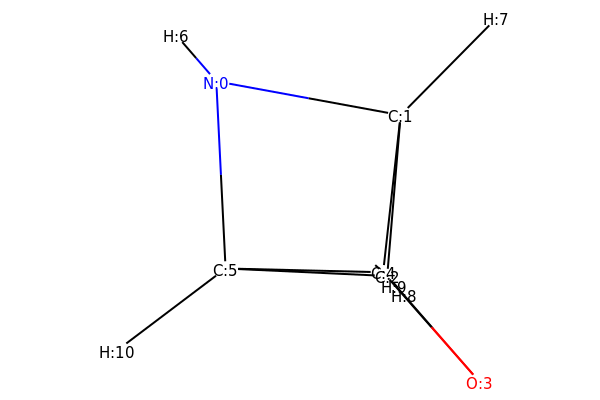

In [52]:
for molname in ['dsgdb9nsd_002018','dsgdb9nsd_002411','dsgdb9nsd_000699']:
    with pd.option_context('display.max_colwidth', -1):
        display(dferror[dferror['molname']==molname])
    display(mol_with_atom_index(qm9mols[molname]))

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

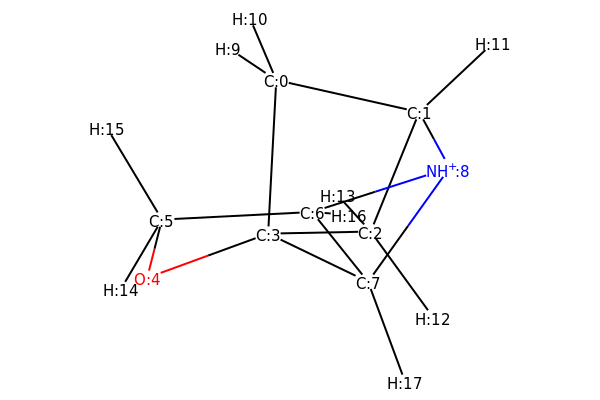

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

Empty DataFrame
Columns: [molname, idx0, idx1, msg, has_error]
Index: []

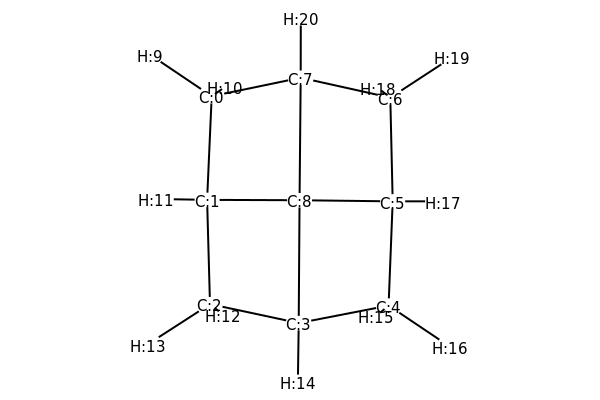

In [51]:
for molname in ['dsgdb9nsd_038230','dsgdb9nsd_059827','dsgdb9nsd_133863']:
    with pd.option_context('display.max_colwidth', -1):
        display(dferror[dferror['molname']==molname])
    display(mol_with_atom_index(qm9mols[molname]))